In [1]:
#download packages
!pip install --quiet --upgrade-strategy only-if-needed qiskit
!pip install --quiet --upgrade-strategy only-if-needed qiskit_aer
!pip install --quiet --upgrade-strategy only-if-needed qiskit-ionq
!pip install --quiet --upgrade-strategy only-if-needed pylatexenc

In [2]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/KHUbit_2025'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#import packages
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from numpy import sqrt
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import PauliEvolutionGate, RZXGate, RXXGate
from qiskit.quantum_info import Statevector
from qiskit_algorithms.optimizers import SPSA
from functools import partial

from scipy.linalg import expm
from scipy.optimize import minimize, Bounds

from types import SimpleNamespace

import matplotlib.pyplot as plt
import numpy as np
import random
from math import log2

In [4]:
#setting API Key for accessing to IONQ
from qiskit_ionq import IonQProvider

provider = IonQProvider(token="IzbdvwNTNys5YFZJ5sZtuanmjrWWuq76") #윤인희꺼 API key
print(provider.backends())

[<IonQSimulatorBackend('ionq_simulator')>, <IonQQPUBackend('ionq_qpu')>]


In [5]:
BACKEND = AerSimulator()
#BACKEND = provider.get_backend("ionq_simulator")
#BACKEND = provider.get_backend("ionq_qpu.aria-1")

In [6]:
#common mixer
def Shape_mixerEvolution(num_nodes: int, beta: float) -> QuantumCircuit:
    num_qubits = num_nodes * (num_nodes - 1)
    U_M = QuantumCircuit(num_qubits)

    for i in range(num_qubits):
        U_M.rx(2*beta, i)

    return U_M

In [7]:
#XY mixer for Dicke state
def edge_mixerEvolution(num_nodes: int, beta: float) -> QuantumCircuit:
    num_qubits = num_nodes * int(log2(num_nodes))
    U_M = QuantumCircuit(num_qubits)

    for i in range(num_qubits):
        for j in range(i + 1, num_qubits):
            U_M.rxx(2 * beta, i, j)
            ryy(U_M, 2 * beta, i, j)


    return U_M

def ryy(qc: QuantumCircuit, theta: float, q0: int, q1: int):
    qc.rx(-np.pi/2, q0)
    qc.rx(-np.pi/2, q1)
    qc.rxx(theta, q0, q1)
    qc.rx(np.pi/2, q0)
    qc.rx(np.pi/2, q1)

In [8]:
#cost for guessing shape of graph
def Shape_QAOA_costEvolution(num_nodes: int, adjacent_matrix: list, gamma: float) -> QuantumCircuit:
    n_qubits = num_nodes * (num_nodes - 1) #n x (n-1) qubits
    U_C = QuantumCircuit(n_qubits)

    lam1 = 1.5
    lam2 = 1.1
    lam3 = 0.2

    #Apply a penalty for using disallowed edges
    for i in range(num_nodes):
        for j in range(num_nodes):
            offset = j
            #If j > i, subtract 1 from the index
            if j > i:
                offset -= 1

            if adjacent_matrix[i][j] == 0 and i != j:
                U_C.rz(-lam1*gamma, i*(num_nodes-1) + offset)

    #Apply a penalty if a node does not have exactly two edges (invalid graph structure)
    #(0.5(1-Z)-2)^2 (Ensure that the energy is minimized when there are exactly two edges)
    for node in range(num_nodes):
        for i in range(num_nodes-1):
            u = node*(num_nodes-1) + i
            # -1.5(I - Z_i)
            U_C.rz(3*lam2*gamma, u)

            for j in range(i + 1, num_nodes - 1):
                v = node*(num_nodes-1) + j

                # (I - Z_i)(I - Z_j) = RZ_i(-γ) RZ_j(-γ) RZZ_ij(γ)
                U_C.rz(-0.5*lam2*gamma, u)
                U_C.rz(-0.5*lam2*gamma, v)
                U_C.cx(u, v)
                U_C.rz(0.5*lam2*gamma, v)
                U_C.cx(u, v)

    #Since it is an undirected graph, if one direction of an edge is set to 1, the opposite direction must also be 1; otherwise, apply a penalty
    def edge_idx(src: int, dst: int, n: int) -> int:
        return src*(n-1) + (dst if dst < src else dst-1)

    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            q_ij = edge_idx(i, j, num_nodes)
            q_ji = edge_idx(j, i, num_nodes)

            U_C.cx(q_ij, q_ji)
            U_C.rz(lam3*gamma, q_ji)
            U_C.cx(q_ij, q_ji)

    return U_C

In [9]:
#Cost evolution in QAOA for determining which edges to use once the graph structure is specified
def edge_QAOA_costEvolution(num_nodes: int, adjacent_matrix: list, gamma: float) -> QuantumCircuit:
    n_qubits = num_nodes * int(log2(num_nodes)) #n x (n-1) qubits
    U_C = QuantumCircuit(n_qubits)

    lam1 = 1
    lam2 = 4
    #Apply a penalty if a disconnected edge is accessed
    #Constructing a Hamiltonian that encodes weights for a given graph
    #Apply a penalty to edges in the first and fourth graphs
    U_C.cx(0, 1)
    U_C.rz(-lam1*gamma, 1)
    U_C.cx(0, 1)

    #Apply a penalty to edges in the second and third graphs
    U_C.cx(2, 3)
    U_C.rz(lam1*gamma, 3)
    U_C.cx(2, 3)

    #Apply a penalty to edges in the first and third graphs
    U_C.rz(-lam1*gamma, 5)

    #Apply a penalty to edges in the fourth graph
    U_C.rz(0.5*lam1*gamma, 6)
    U_C.rz(0.5*lam1*gamma, 7)
    U_C.cx(6, 7)
    U_C.rz(-0.5*lam1*gamma, 7)
    U_C.cx(6, 7)

    #Apply a penalty if nodes from different graphs overlap, as this is not allowed
    def kbody_Z_rotation(qc, qubits, theta):
        if len(qubits) == 1:
            qc.rz(theta, qubits[0])
            return

        for q in qubits[:-1]:
            qc.cx(q, qubits[-1])

        qc.rz(theta, qubits[-1])

        for q in reversed(qubits[:-1]):
            qc.cx(q, qubits[-1])

    for i in range(num_nodes-1):
        for j in range(i+1, num_nodes):
            qa0, qb0, qa1, qb1 = 2*i, 2*j, 2*i+1, 2*j+1
            kbody_Z_rotation(U_C, [qa0, qb0], -0.5*lam2*gamma)
            kbody_Z_rotation(U_C, [qa1, qb1], -0.5*lam2*gamma)
            kbody_Z_rotation(U_C, [qa0, qa1, qb0, qb1], -0.5*lam2*gamma)

    return U_C

In [10]:
#Shape QAOA Quantum circuit implementation
def Shape_createQC(params: list, num_nodes: int, adjacent_matrix: list, p: int) -> QuantumCircuit:
    num_qubits = num_nodes * (num_nodes - 1)
    qc = QuantumCircuit(num_qubits, num_qubits)

    gammas = params[:p]
    betas = params[p:]

    #init state
    for i in range(num_qubits):
        qc.h(i)

    for i in range(p):
        #cost Layer
        qc = qc.compose(Shape_QAOA_costEvolution(num_nodes, adjacent_matrix, gammas[i]))

        #mixer Layer
        qc = qc.compose(Shape_mixerEvolution(num_nodes, betas[i]))

    for i in range(num_qubits):
        qc.measure(i, i)

    return qc

In [ ]:
#Edge QAOA Quantum circuit implementation
def edge_createQC(params: list, num_nodes: int, adjacent_matrix: list, p: int) -> QuantumCircuit:
    num_qubits = num_nodes * int(log2(num_nodes))
    qc = QuantumCircuit(num_qubits, num_qubits)

    gammas = params[:p]
    betas = params[p:]

    #init state (Add the (8,4) Dicke state to enforce the constraint that exactly four qubits are in the 1 state)
    qc = qc.compose(build_dicke_84_native(measure=False))

    for i in range(p):
        #cost Layer
        qc = qc.compose(edge_QAOA_costEvolution(num_nodes, adjacent_matrix, gammas[i]))

        #mixer Layer
        qc = qc.compose(edge_mixerEvolution(num_nodes, betas[i]))

    for i in range(num_qubits):
        qc.measure(i, i)

    return qc

In [12]:
#Edge overlap QAOA Quantum circuit implementation
def edge_overlap_createQC(params: list, num_nodes: int, adjacent_matrix: list, p: int) -> QuantumCircuit:
    num_qubits = num_nodes * int(log2(num_nodes))
    qc = QuantumCircuit(num_qubits, num_qubits)

    gammas = params[:p]
    betas = params[p:]

    #init state (Add the (8,4) Dicke state to enforce the constraint that the number of 1s is always limited to 4)
    qc = qc.compose(build_dicke_84_native(measure=False))

    for i in range(p):
        #cost Layer
        qc = qc.compose(edge_QAOA_costEvolution(num_nodes, adjacent_matrix, gammas[i]))

        #Apply a penalty if the previous QAOA output is 10110100 and there are overlapping values
        qc = qc.compose(ovelap_costEvolution(num_qubits, gammas[i]))

        #mixer Layer
        qc = qc.compose(edge_mixerEvolution(num_nodes, betas[i]))

    for i in range(num_qubits):
        qc.measure(i, i)

    return qc

#Apply a penalty to any state that overlaps with the previously obtained solution
def ovelap_costEvolution(num_qubits: int, gamma: float) -> QuantumCircuit:
    lam = 1
    U_C = QuantumCircuit(num_qubits)

    #first slot 10 panalty
    U_C.rz(0.5*lam*gamma, 0)
    U_C.rz(-0.5*lam*gamma, 1)
    U_C.cx(0, 1)
    U_C.rz(-0.5*lam*gamma, 1)
    U_C.cx(0, 1)

    #second slot 11 panalty
    U_C.rz(0.5*lam*gamma, 2)
    U_C.rz(0.5*lam*gamma, 3)
    U_C.cx(2, 3)
    U_C.rz(-0.5*lam*gamma, 3)
    U_C.cx(2, 3)

    #third slot 01 panalty
    U_C.rz(-0.5*lam*gamma, 4)
    U_C.rz(0.5*lam*gamma, 5)
    U_C.cx(4, 5)
    U_C.rz(0.5*lam*gamma, 5)
    U_C.cx(4, 5)

    #fourth slot 00 panalty
    U_C.rz(-0.5*lam*gamma, 6)
    U_C.rz(-0.5*lam*gamma, 7)
    U_C.cx(6, 7)
    U_C.rz(-0.5*lam*gamma, 7)
    U_C.cx(6, 7)
    '''
    #first slot 01 panalty
    U_C.rz(-0.5*lam*gamma, 0)
    U_C.rz(0.5*lam*gamma, 1)
    U_C.cx(0, 1)
    U_C.rz(-0.5*lam*gamma, 1)
    U_C.cx(0, 1)

    #second slot 00 panalty
    U_C.rz(-0.5*lam*gamma, 2)
    U_C.rz(-0.5*lam*gamma, 3)
    U_C.cx(2, 3)
    U_C.rz(-0.5*lam*gamma, 3)
    U_C.cx(2, 3)

    #third slot 11 panalty
    U_C.rz(0.5*lam*gamma, 4)
    U_C.rz(0.5*lam*gamma, 5)
    U_C.cx(4, 5)
    U_C.rz(-0.5*lam*gamma, 5)
    U_C.cx(4, 5)

    #fourth slot 10 panalty
    U_C.rz(0.5*lam*gamma, 6)
    U_C.rz(-0.5*lam*gamma, 7)
    U_C.cx(6, 7)
    U_C.rz(-0.5*lam*gamma, 7)
    U_C.cx(6, 7)
    '''
    return U_C

In [13]:
from typing import List
from math import asin, sqrt
from qiskit.circuit import QuantumRegister, ClassicalRegister
from qiskit.circuit.library import RYGate

#Create a Dicke state for initialization
def _dicke_recursive(qc: QuantumCircuit, qs: List[int], k: int):
    n = len(qs)
    if k == 0:
        return
    if k == n:
        for q in qs:
            qc.x(q)
        return

    target, rest = qs[0], qs[1:]
    theta = 2 * asin(sqrt(k / n))
    qc.ry(theta, target)

    qc.x(target)
    _dicke_recursive_ctrl(qc, rest, k, [target])
    qc.x(target)

    _dicke_recursive_ctrl(qc, rest, k - 1, [target])

def _dicke_recursive_ctrl(qc: QuantumCircuit, qs: List[int], k: int, ctrls: List[int]):
    n = len(qs)
    if k == 0:
        return
    if k == n:
        for q in qs:
            qc.mcx(ctrls, q)
        return

    target, rest = qs[0], qs[1:]
    theta = 2 * asin(sqrt(k / n))
    qc.append(RYGate(theta).control(len(ctrls)), ctrls + [target])

    qc.x(target)
    _dicke_recursive_ctrl(qc, rest, k, ctrls + [target])
    qc.x(target)

    _dicke_recursive_ctrl(qc, rest, k - 1, ctrls + [target])


def build_dicke_84_native(measure: bool = False, opt: int = 3):
    q = QuantumRegister(8, "q")
    c = ClassicalRegister(8, "c") if measure else None
    qc = QuantumCircuit(q, c) if measure else QuantumCircuit(q)

    _dicke_recursive(qc, list(range(8)), 4)
    if measure:
        qc.measure(q, c)

    qc = transpile(qc, BACKEND, optimization_level=opt)

    return qc

In [14]:
#measure with backend
def measure(backend, qc: QuantumCircuit, shots: int) -> dict:
    result = backend.run(transpile(qc, backend), shots=shots).result()
    counts = result.get_counts()

    #measurement outcome picture
    #plot_histogram(counts)
    #plt.show()

    return counts

In [15]:
#calculate expectation value
def Shape_ExpCost(counts: dict, shots: int, adjacent_matrix: list, num_nodes: int)-> float:
    def costfunc(bitstring: str, adjacent_matrix: list)-> float:
        cost = 0

        lam1 = 1.5
        lam2 = 1.1
        lam3 = 0.2

        #In Qiskit, bitstrings are interpreted in reverse order
        bitstring = bitstring[::-1]

        for i in range(num_nodes):
            for j in range(num_nodes):
                offset = j
                #If j > i, subtract 1 from the index
                if j > i:
                    offset -= 1

                if adjacent_matrix[i][j] == 0 and i != j:
                    Z_e = 1 if bitstring[i*(num_nodes-1) + offset] == '0' else -1
                    cost += lam1*0.5*(1 - Z_e)

        for node in range(num_nodes):
            for i in range(num_nodes-1):
                u = node*(num_nodes-1) + i
                Z_i = 1 if bitstring[u] == '0' else -1
                cost += lam2*-1.5*(1 - Z_i)

                for j in range(i + 1, num_nodes - 1):
                    if i != j:
                        v = node*(num_nodes-1) + j
                        Z_u = 1 if bitstring[u] == '0' else -1
                        Z_v = 1 if bitstring[v] == '0' else -1
                        cost += lam2*0.5*(1 - Z_u)*(1 - Z_v)

        cost += lam2*4

        def edge_idx(src: int, dst: int, n: int) -> int:
            return src*(n-1) + (dst if dst < src else dst-1)

        for i in range(num_nodes):
            for j in range(i+1, num_nodes):
                q_ij = edge_idx(i, j, num_nodes)
                q_ji = edge_idx(j, i, num_nodes)
                Z_u = 1 if bitstring[q_ij] == '0' else -1
                Z_v = 1 if bitstring[q_ji] == '0' else -1
                cost += lam3*0.5*(1 - Z_u*Z_v)

        return cost

    exp = sum(
        (count / shots) * costfunc(bitstring, adjacent_matrix)
        for bitstring, count in counts.items()
    )

    return exp

In [16]:
def edge_ExpCost(counts: dict, shots: int, adjacent_matrix: list, num_nodes: int)-> float:
    def costfunc(bitstring: str, adjacent_matrix: list)-> float:
        cost = 0

        lam1 = 1.4
        lam2 = 3.8

        #In Qiskit, bitstrings are interpreted in reverse order
        bitstring = bitstring[::-1]

        Z_0 = 1 if bitstring[0] == '0' else -1
        Z_1 = 1 if bitstring[1] == '0' else -1
        Z_2 = 1 if bitstring[2] == '0' else -1
        Z_3 = 1 if bitstring[3] == '0' else -1
        Z_4 = 1 if bitstring[4] == '0' else -1
        Z_5 = 1 if bitstring[5] == '0' else -1
        Z_6 = 1 if bitstring[6] == '0' else -1
        Z_7 = 1 if bitstring[7] == '0' else -1

        cost += lam1*0.5*(1 + Z_0*Z_1)
        cost += lam1*0.5*(1 - Z_2*Z_3)
        cost += lam1*0.5*(1 - Z_5)
        cost += lam1*0.25*(1 - Z_6)*(1 - Z_7)

        for i in range(num_nodes-1):
            for j in range(i+1, num_nodes):
                qa0, qb0, qa1, qb1 = 2*i, 2*j, 2*i+1, 2*j+1
                Z_i0 = 1 if bitstring[qa0] == '0' else -1
                Z_i1 = 1 if bitstring[qa1] == '0' else -1
                Z_j0 = 1 if bitstring[qb0] == '0' else -1
                Z_j1 = 1 if bitstring[qb1] == '0' else -1

                cost += lam2* 1/4 * (1 + Z_i0*Z_j0)*(1 + Z_i1*Z_j1)

        return cost

    exp = sum(
        (count / shots) * costfunc(bitstring, adjacent_matrix)
        for bitstring, count in counts.items()
    )

    return exp

In [17]:
def edge_overlap_ExpCost(counts: dict, shots: int, adjacent_matrix: list, num_nodes: int)-> float:
    def costfunc(bitstring: str, adjacent_matrix: list)-> float:
        cost = 0

        lam1 = 2.66
        lam2 = 3.29
        lam3 = 1.5

        #In Qiskit, bitstrings are interpreted in reverse order
        bitstring = bitstring[::-1]

        Z_0 = 1 if bitstring[0] == '0' else -1
        Z_1 = 1 if bitstring[1] == '0' else -1
        Z_2 = 1 if bitstring[2] == '0' else -1
        Z_3 = 1 if bitstring[3] == '0' else -1
        Z_4 = 1 if bitstring[4] == '0' else -1
        Z_5 = 1 if bitstring[5] == '0' else -1
        Z_6 = 1 if bitstring[6] == '0' else -1
        Z_7 = 1 if bitstring[7] == '0' else -1

        cost += lam1*0.5*(1 + Z_0*Z_1)
        cost += lam1*0.5*(1 - Z_2*Z_3)
        cost += lam1*0.5*(1 - Z_5)
        cost += lam1*0.25*(1 - Z_6)*(1 - Z_7)

        for i in range(num_nodes-1):
            for j in range(i+1, num_nodes):
                qa0, qb0, qa1, qb1 = 2*i, 2*j, 2*i+1, 2*j+1
                Z_i0 = 1 if bitstring[qa0] == '0' else -1
                Z_i1 = 1 if bitstring[qa1] == '0' else -1
                Z_j0 = 1 if bitstring[qb0] == '0' else -1
                Z_j1 = 1 if bitstring[qb1] == '0' else -1

                cost += lam2* 1/4 * (1 + Z_i0*Z_j0)*(1 + Z_i1*Z_j1)


        #10110100 panalty
        cost += lam3 * 1/4 * (1-Z_0)*(1+Z_1)
        cost += lam3 * 1/4 * (1-Z_2)*(1-Z_3)
        cost += lam3 * 1/4 * (1+Z_4)*(1-Z_5)
        cost += lam3 * 1/4 * (1+Z_6)*(1+Z_7)

        #01001110 panalty
        #cost += lam3 * 1/4 * (1+Z_0)*(1-Z_1)
        #cost += lam3 * 1/4 * (1+Z_2)*(1+Z_3)
        #cost += lam3 * 1/4 * (1-Z_4)*(1-Z_5)
        #cost += lam3 * 1/4 * (1-Z_6)*(1+Z_7)

        return cost

    exp = sum(
        (count / shots) * costfunc(bitstring, adjacent_matrix)
        for bitstring, count in counts.items()
    )

    return exp

In [18]:
def Shape_QAOA_Objective(params: list, nodes: list, adjacent_matrix: list, p: int, shots: int):
    num_nodes = len(nodes)
    qc = Shape_createQC(params, num_nodes, adjacent_matrix, p)

    #circuit picture
    #qc.draw('mpl')
    #plt.show()

    #Measure to see which state occurs most frequently
    counts = measure(BACKEND, qc, shots)

    #cost calculate
    cost = Shape_ExpCost(counts, shots, adjacent_matrix, num_nodes)

    return cost

In [19]:
def edge_QAOA_Objective(params: list, nodes: list, adjacent_matrix: list, p: int, shots: int):
    num_nodes = len(nodes)
    qc = edge_createQC(params, num_nodes, adjacent_matrix, p)

    #circuit picture
    #qc.draw('mpl')
    #plt.show()

    #Measure to see which state occurs most frequently
    counts = measure(BACKEND, qc, shots)

    #cost calculate
    cost = edge_ExpCost(counts, shots, adjacent_matrix, num_nodes)

    return cost

In [20]:
def edge_overlap_QAOA_Objective(params: list, nodes: list, adjacent_matrix: list, p: int, shots: int):
    num_nodes = len(nodes)
    qc = edge_overlap_createQC(params, num_nodes, adjacent_matrix, p)

    #circuit picture
    #qc.draw('mpl')
    #plt.show()

    #Measure to see which state occurs most frequently
    counts = measure(BACKEND, qc, shots)

    #cost calculate
    cost = edge_overlap_ExpCost(counts, shots, adjacent_matrix, num_nodes)

    return cost

In [21]:
#Parameter shift rule to be used in the optimizer
def _parameter_shift_grad(fun, params, shift=np.pi/2, *fargs, **fkwargs):
    grad = np.zeros_like(params)
    for i in range(len(params)):
        plus  = params.copy(); plus[i]  += shift
        minus = params.copy(); minus[i] -= shift
        f_plus  = fun(plus,  *fargs, **fkwargs)
        f_minus = fun(minus, *fargs, **fkwargs)
        grad[i] = 0.5 * (f_plus - f_minus)
    return grad

In [22]:
#Subroutine to be executed as the main routine
def Shape_QAOA(nodes: list, adjacent_matrix: list, gammas: list, betas: list, p: int, shots: int) -> str:
    init_param = gammas + betas

    #Numerically find the parameters that minimize the penalty
    #bnds = Bounds([0]*p+[0]*p, [np.pi]*p + [np.pi/2]*p)
    res_cobyla = minimize(
        Shape_QAOA_Objective,
        init_param,
        args=(nodes, adjacent_matrix, p, shots),
        method='COBYLA',
        options={
            'maxiter': 1500,
            'tol': 5e-3,
            'rhobeg': 0.25*np.pi,
            'disp': True
        }
    )
    coarse_param = res_cobyla.x

    res = minimize(
        Shape_QAOA_Objective,
        coarse_param,
        args=(nodes, adjacent_matrix, p, shots),
        method='L-BFGS-B',
        jac=lambda x, *a: _parameter_shift_grad(
            Shape_QAOA_Objective, x, np.pi/2, *a),
        options={
            'maxiter': 800,
            'ftol': 1e-4,
            'disp': True
        }
    )

   #Regenerate the circuit using the optimal parameters
    optimal_params = res.x
    qc = Shape_createQC(optimal_params, len(nodes), adjacent_matrix, p)

    #Measure again
    counts = measure(BACKEND, qc, shots)

    draw_graph(counts)

    #The bitstring with the highest frequency is the optimal solution
    answer = max(counts, key=counts.get)

    #circuit pircutre
    qc.draw('mpl')
    circuit_file = os.path.join(path, 'circuit.png')
    plt.savefig(circuit_file, dpi=300)

    answer = answer[::-1]
    graph = [[0, 0, 0, 0],
             [0, 0, 0, 0],
             [0, 0, 0, 0],
             [0, 0, 0, 0]]

    num_nodes = len(nodes)
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i == j:
                continue
            index = i*(num_nodes-1) + j
            if i < j:
                index -= 1
            if answer[index] == '1':
                graph[i][j] = 1

    string = 'correct edge : '

    for i in range(num_nodes):
        num = 0
        for j in range(num_nodes):
            if graph[i][j] == 1:
                num += 1
        if num > 2:
            string = 'wrong answer! : '
            string += answer
            return string

    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            if graph[i][j] == 1 and graph[j][i] != 1:
                string = 'wrong answer! : '
                string += answer
                return string
            elif graph[i][j] == 1 and graph[j][i] == 1:
                if i == 0:
                    string += 'R'
                elif i == 1:
                    string += 'B'
                elif i == 2:
                    string += 'G'
                elif i == 3:
                    string += 'W'
                string += '-'
                if j == 0:
                    string += 'R'
                elif j == 1:
                    string += 'B'
                elif j == 2:
                    string += 'G'
                elif j == 3:
                    string += 'W'

                string += '  '

    return string

In [23]:
def edge_QAOA(nodes: list, adjacent_matrix: list, gammas: list, betas: list, p: int, shots: int) -> str:
    init_param = gammas + betas

    #Numerically find the parameters that minimize the penalty
    #bnds = Bounds([0]*p+[0]*p, [np.pi]*p + [np.pi/2]*p)
    res_cobyla = minimize(
        edge_QAOA_Objective,
        init_param,
        args=(nodes, adjacent_matrix, p, shots),
        method='COBYLA',
        options={
            'maxiter': 1500,
            'tol': 5e-3,
            'rhobeg': 0.25*np.pi,
            'disp': True
        }
    )
    coarse_param = res_cobyla.x

    res = minimize(
        edge_QAOA_Objective,
        coarse_param,
        args=(nodes, adjacent_matrix, p, shots),
        method='L-BFGS-B',
        jac=lambda x, *a: _parameter_shift_grad(
            edge_QAOA_Objective, x, np.pi/2, *a),
        options={
            'maxiter': 800,
            'ftol': 1e-4,
            'disp': True
        }
    )

   #Rebuild the circuit with optimal parameters to get the final result
    optimal_params = res.x
    qc = edge_createQC(optimal_params, len(nodes), adjacent_matrix, p)

    #measure again
    counts = measure(BACKEND, qc, shots)

    draw_graph(counts)

    #The bitstring with the highest frequency is the optimal solution
    answer = max(counts, key=counts.get)

    #circuit picture
    fig = qc.draw('mpl')
    circuit_file = os.path.join(path, 'circuit.png')
    fig.savefig(circuit_file, dpi=300)


    num_nodes = len(nodes)
    answer = answer[::-1]
    edges = ['R-B : ', 'R-G : ', 'B-W : ', 'W-G : ']
    string = ''
    for i in range(num_nodes):
      u = 2*i
      v = 2*i + 1
      string += edges[i]
      if answer[u] == '0' and answer[v] == '0':
          string += '1'
      elif answer[u] == '0' and answer[v] == '1':
          string += '2'
      elif answer[u] == '1' and answer[v] == '0':
          string += '3'
      elif answer[u] == '1' and answer[v] == '1':
          string += '4'

      string += '  '

    return string

In [24]:
def edge_overlap_QAOA(nodes: list, adjacent_matrix: list, gammas: list, betas: list, p: int, shots: int) -> str:
    init_param = gammas + betas

    #Numerically find the parameters that minimize the penalty
    #bnds = Bounds([0]*p+[0]*p, [np.pi]*p + [np.pi/2]*p)
    res_cobyla = minimize(
        edge_overlap_QAOA_Objective,
        init_param,
        args=(nodes, adjacent_matrix, p, shots),
        method='COBYLA',
        options={
            'maxiter': 1500,
            'tol': 5e-3,
            'rhobeg': 0.25*np.pi,
            'disp': True
        }
    )
    coarse_param = res_cobyla.x

    res = minimize(
        edge_overlap_QAOA_Objective,
        coarse_param,
        args=(nodes, adjacent_matrix, p, shots),
        method='L-BFGS-B',
        jac=lambda x, *a: _parameter_shift_grad(
            edge_overlap_QAOA_Objective, x, np.pi/2, *a),
        options={
            'maxiter': 800,
            'ftol': 1e-4,
            'disp': True
        }
    )

    #Rebuild the circuit with optimal parameters to get the final result
    optimal_params = res.x
    qc = edge_overlap_createQC(optimal_params, len(nodes), adjacent_matrix, p)

    #measure again
    counts = measure(BACKEND, qc, shots)

    draw_graph(counts)

    #The bitstring with the highest frequency is the optimal solution
    answer = max(counts, key=counts.get)

    #circuit picture
    fig = qc.draw('mpl')
    circuit_file = os.path.join(path, 'circuit.png')
    fig.savefig(circuit_file, dpi=300)

    num_nodes = len(nodes)
    answer = answer[::-1]
    edges = ['R-B : ', 'R-G : ', 'B-W : ', 'W-G : ']
    string = ''
    for i in range(num_nodes):
      u = 2*i
      v = 2*i + 1
      string += edges[i]
      if answer[u] == '0' and answer[v] == '0':
          string += '1'
      elif answer[u] == '0' and answer[v] == '1':
          string += '2'
      elif answer[u] == '1' and answer[v] == '0':
          string += '3'
      elif answer[u] == '1' and answer[v] == '1':
          string += '4'

      string += '  '

    return string

In [25]:
import csv
import os
from datetime import datetime

#save log as csv file
def save_log(nodes: str, edges: str, shots: int, p: int, result: str) -> None:
    log_file = os.path.join(path, 'log.csv')
    file_exists = os.path.exists(log_file)

    now = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    row = [now, nodes, edges, shots, p, result]

    with open(log_file, mode='a', newline='') as f:
        writer = csv.writer(f)
        if not file_exists:
            writer.writerow(['Time', 'Nodes', 'Edges', 'Shots', 'Layer Num', 'Result'])
        writer.writerow(row)

In [26]:
#Plot a bar chart
def draw_graph(counts: dict):
    sorted_counts = sorted(counts.items(), key=lambda item: item[1], reverse=True)[:7]

    bitstrings, frequencies = zip(*sorted_counts)

    plt.figure(figsize=(10, 5))
    plt.bar(bitstrings, frequencies)
    plt.xlabel('bitstring')
    plt.ylabel('count')
    plt.title('Qiskit Aer backend measure')
    plt.tight_layout()

    result_file = os.path.join(path, 'result.png')
    plt.savefig(result_file, dpi=300)

Although we would like to present all function execution results in a single file, due to the structure of the algorithm, the Hamiltonian penalty must be encoded based on the output of the previous algorithm, requiring sequential execution. Additionally, due to the uniqueness constraint of the main function in our code architecture, it is not possible to display all results at once. Therefore, if you would like to run the results yourself, please execute the following three functions in order as described below.

Note: Based on Aer simulation, Shape_QAOA takes approximately 30 seconds to 1 minute, while edge_QAOA and edge_overlap_QAOA take about 3 to 7 minutes each. Execution time may vary depending on your hardware environment.
When using the IonQ simulator, the total runtime may be 2 to 3 times longer.

correct edge : R-B  R-G  B-W  G-W  
[2.209389506887098, 2.148808420475761, 1.1509497657380832]
[3.135079547573132, 1.1302180928040433, 1.3024013614009196]


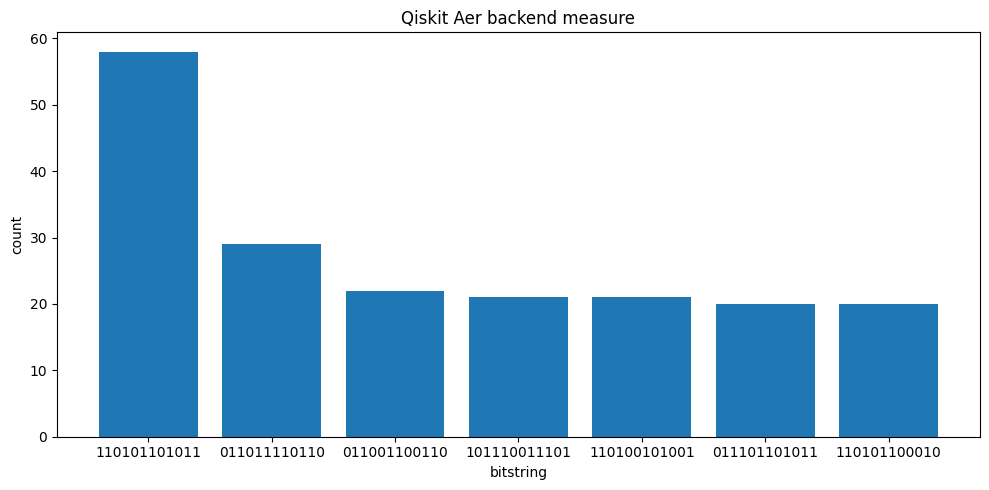

In [27]:
#main function
if __name__=='__main__':
    nodes = [0, 1, 2, 3]
    edges = [[0, 1, 1, 1],
             [1, 0, 0, 1],
             [1, 0, 0, 1],
             [1, 1, 1, 0]]

    #How many shots?
    shots = 4096

    #QAOA depth
    p = 3

    #parameter random initialize
    #gammas = [random.uniform(np.pi/4, 3*np.pi/4) for _ in range(p)]
    #betas = [random.uniform(0, np.pi) for _ in range(p)]

    #First QAOA heuristic initial param to doing warm-start
    gammas = [random.uniform(2.2, 2.4), random.uniform(2.1, 2.3), random.uniform(1.1, 1.3)]
    betas = [random.uniform(3.0, 3.2), random.uniform(1.1, 1.3), random.uniform(1.2, 1.4)]

    #Second QAOA heuristic initial param to doing warm-start
    #gammas = [random.uniform(1.3, 1.5), random.uniform(1.3, 1.5), random.uniform(0.8, 1.0)]
    #betas = [random.uniform(2.3, 2.5), random.uniform(0.4, 0.6), random.uniform(0.9, 1.1)]

    #Third QAOA overlap 01001110 heuristic initial param to doing warm-start
    #gammas = [random.uniform(1.3, 1.5), random.uniform(2.0, 2.2), random.uniform(1.1, 1.3)]
    #betas = [random.uniform(1.5, 1.7), random.uniform(2.1, 2.3), random.uniform(0.0, 0.2)]

    #Third QAOA overlap 10110100 heuristic initial param to doing warm-start
    #gammas = [random.uniform(0.9, 1.1), random.uniform(0.9, 1.1), random.uniform(1.9, 2.1)]
    #betas = [random.uniform(2.0, 2.2), random.uniform(0.5, 0.7), random.uniform(2.6, 2.8)]

    #execute QAOA
    '''
    Please select one of the QAOA functions to execute
    Shape_QAOA : QAOA that determines the shape of a subgraph when the information of a cube net is encoded into a graph
    edge_QAOA : QAOA for selecting a specific edge in a given graph structure
    edge_overlap_QAOA : A QAOA that finds additional feasible edges which do not overlap in node indices with the edge selected in the second QAOA
    '''
    answer = Shape_QAOA(nodes, edges, gammas, betas, p, shots)

    print(answer)
    print(gammas)
    print(betas)

    save_log(str(nodes), str(edges), shots, p, answer)